# Compound library seacrhes with generic Mucko scaffolds

### Import modules

In [1]:
import pandas as pd
from tqdm import tqdm
import rdkit
from rdkit import RDLogger
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import MolsMatrixToGridImage

from venny4py.venny4py import *
import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.simplefilter("ignore")
RDLogger.DisableLog("rdApp.*")  # suppress rdkit warnings

# Load compounds libraries

* Enamine - https://enamine.net/ (Restricted)
* ReFRAMEDB - https://reframedb.org/ (Open source)
* COCONUT - https://coconut.naturalproducts.net/ (Open source)

In [3]:
enamine_df = pd.read_excel(
    "../data/Enamine/Enamine_smiles.xlsx",
    engine="openpyxl",
)
enamine_df.drop_duplicates(subset="ID", inplace=True)
enamine_df.head(1)

,ID,Smile,Name,Molecule (Canonical)
0,Z840028898,CS(=O)(=O)NCCCN(CC1=CC=CO1)C2CCCC2,N-{3-[cyclopentyl(furan-2-ylmethyl)amino]propy...,CS(=O)(=O)NCCCN(Cc1ccco1)C1CCCC1


In [4]:
reframe_df = pd.read_csv("../data/library/reframe_smiles_list.csv")
reframe_df.drop_duplicates(subset="calibr_id", inplace=True)
reframe_df.head(1)

,calibr_id,rfm_id,smile,canonical_ikey,name,source,source_id,status,reframedb_url
0,CBR-001-574-225-3,RFM-003-021-7,COc1cc2ncnc(Oc3cccc(NC(=O)Nc4cc(C(C)(C)C(F)(F)...,DKNUPRMJNUQNHR,RXDX-105,Selleck Chemicals,S8015,plated and available for follow-up,"=HYPERLINK(""https://reframedb.org//compound_da..."


In [5]:
# time consuming
coconut_df = PandasTools.LoadSDF("../data/library/COCONUT/January 2022/COCONUT_DB.sdf")
coconut_df.drop_duplicates(subset="coconut_id", inplace=True)
coconut_df.head(1)

,coconut_id,inchi,inchikey,SMILES,sugar_free_smiles,molecular_formula,molecular_weight,citationDOI,textTaxa,name,...,number_of_rings,total_atom_number,bond_count,found_in_databases,murko_framework,alogp,apol,topoPSA,ID,ROMol
1,CNP0000002,InChI=1S/C27H36N2O15S/c1-5-12(29-9-45)26(37)44...,FJEMIESGEMWDOB-UHFFFAOYSA-N,O=C(O)C=1C(=O)C(O)(CC(=O)C1N)C2OC(COC(=O)C)C(O...,O=C(O)C=1C(=O)C(O)CC(=O)C1N,C27H36N2O15S,660.6463016716552,[],[notax],5-{6-[(acetyloxy)methyl]-3-hydroxy-4-[(5-hydro...,...,,81,47,[chemspidernp],C1=CCCCC1,-2.4338000000000015,88.65454800000002,298.83,,<rdkit.Chem.rdchem.Mol object at 0x0000011CE9E...


In [6]:
nd_compounds = pd.read_csv("../data/ntd_drugs.tsv", sep="\t")
nd_compounds.drop_duplicates(subset=["chembl_id"], inplace=True)
nd_compounds.head(2)

,chembl_id,pref_name,canonical_smiles,standard_inchi,standard_inchi_key,max_phase,indication_class,withdrawn_flag,black_box_warning,drugind_id,max_phase_for_ind,mesh_id,mesh_heading,ref_type,ref_id,ref_url
0,CHEMBL1200689,NITRIC OXIDE,[N]=O,InChI=1S/NO/c1-2,MWUXSHHQAYIFBG-UHFFFAOYSA-N,4.0,NaN,0,0,23580,3.0,D016773,"Leishmaniasis, Cutaneous",ClinicalTrials,NCT00317629,https://clinicaltrials.gov/ct2/results?id=%22N...
1,CHEMBL131,PREDNISOLONE,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,InChI=1S/C21H28O5/c1-19-7-5-13(23)9-12(19)3-4-...,OIGNJSKKLXVSLS-VWUMJDOOSA-N,4.0,Glucocorticoid,0,0,24801,2.0,D007918,Leprosy,ClinicalTrials,"NCT00919542,NCT00919776,NCT00919815",https://clinicaltrials.gov/ct2/results?id=%22N...


# Add in generic scaffolds to the database

In [7]:
ids_to_inchikey = {}

for idx, smiles in tqdm(enamine_df[["ID", "Molecule (Canonical)"]].values):
    if pd.isna(smiles):
        ids_to_inchikey[idx] = None
        continue

    mol = rdkit.Chem.MolFromSmiles(smiles)
    if mol is None:
        ids_to_inchikey[idx] = None
        continue

    inchikey = rdkit.Chem.inchi.MolToInchiKey(mol)
    ids_to_inchikey[idx] = inchikey

100%|██████████| 200057/200057 [02:52<00:00, 1160.40it/s]


In [8]:
enamine_df["inchikey"] = enamine_df["ID"].map(ids_to_inchikey)
enamine_df["main_scaffold"] = enamine_df["inchikey"].apply(
    lambda x: x.split("-")[0] if x is not None else None
)

In [9]:
nd_compounds["main_scaffold"] = nd_compounds["standard_inchi_key"].apply(
    lambda x: x.split("-")[0] if x is not None else None
)

In [10]:
coconut_df["main_scaffold"] = coconut_df["inchikey"].apply(
    lambda x: x.split("-")[0] if x is not None else None
)

In [11]:
print(
    f"""Enamine: {enamine_df['main_scaffold'].nunique()} unique main scaffolds
ReFRAME: {reframe_df['canonical_ikey'].nunique()} unique main scaffolds
COCONUT: {coconut_df['main_scaffold'].nunique()} unique main scaffolds
ND: {nd_compounds['main_scaffold'].nunique()} unique main scaffolds
"""
)

Enamine: 200051 unique main scaffolds
ReFRAME: 12168 unique main scaffolds
COCONUT: 406567 unique main scaffolds
ND: 45 unique main scaffolds



# Venn diagram on overlaps

In [12]:
reframe_ids_to_inchikey = {}

for idx, smiles in tqdm(reframe_df[["calibr_id", "smile"]].values):
    if pd.isna(smiles):
        reframe_ids_to_inchikey[idx] = None
        continue

    mol = rdkit.Chem.MolFromSmiles(smiles)
    if mol is None:
        reframe_ids_to_inchikey[idx] = None
        continue

    inchikey = rdkit.Chem.inchi.MolToInchiKey(mol)
    reframe_ids_to_inchikey[idx] = inchikey

reframe_df["inchikey"] = reframe_df["calibr_id"].map(reframe_ids_to_inchikey)

100%|██████████| 12790/12790 [00:15<00:00, 826.47it/s] 


In [13]:
# drop duplicates in each set
main_cmps = nd_compounds["standard_inchi_key"].unique()

enamine_df = enamine_df[~enamine_df["inchikey"].isin(main_cmps)]
reframe_df = reframe_df[~reframe_df["inchikey"].isin(main_cmps)]
coconut_df = coconut_df[~coconut_df["inchikey"].isin(main_cmps)]

<Figure size 1000x1000 with 0 Axes>

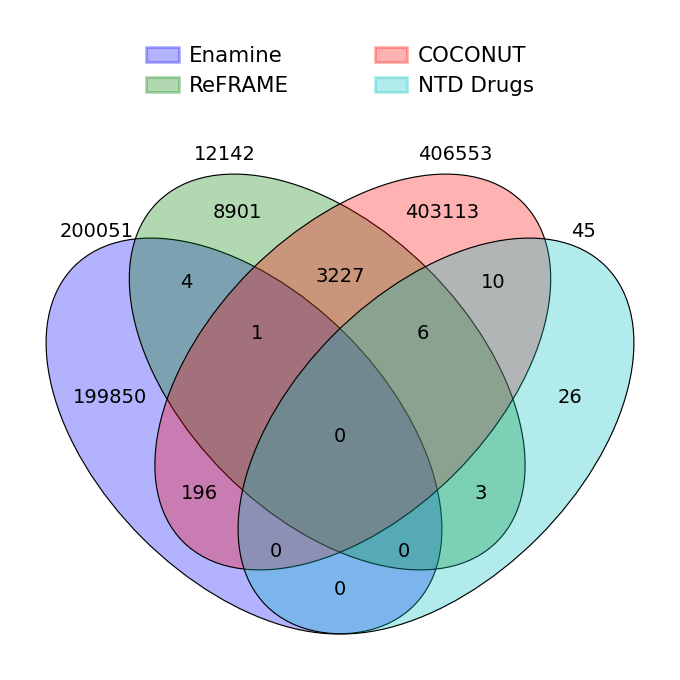

In [14]:
# dict of sets
cmpd_sets = {
    "Enamine": set(enamine_df["main_scaffold"].unique()),
    "ReFRAME": set(reframe_df["canonical_ikey"].unique()),
    "COCONUT": set(coconut_df["main_scaffold"].unique()),
    "NTD Drugs": set(nd_compounds["main_scaffold"].unique()),
}

plt.figure(figsize=(10, 10))
venny4py(sets=cmpd_sets)
plt.tight_layout()
plt.savefig("../figures/compound_venn_diagram.png", dpi=300)
plt.show()

# Looking into common scaffolds

In [15]:
common_scaffolds = (
    cmpd_sets["COCONUT"]
    .intersection(cmpd_sets["NTD Drugs"])
    .union(cmpd_sets["ReFRAME"].intersection(cmpd_sets["NTD Drugs"]))
)
print(f"Common scaffolds: {len(common_scaffolds)}")

Common scaffolds: 19


In [16]:
main_data = []
main_labels = []

for idx, scaffold in tqdm(enumerate(common_scaffolds), total=len(common_scaffolds)):
    nd_matches = nd_compounds[nd_compounds["main_scaffold"] == scaffold]

    tmp = [
        rdkit.Chem.MolFromSmiles(smile)
        for smile in nd_matches["canonical_smiles"].values
    ]

    label = nd_matches["pref_name"].values.tolist()

    # reframe
    reframe_matches = reframe_df[reframe_df["canonical_ikey"] == scaffold]
    if not reframe_matches.empty:
        tmp.extend(
            [
                rdkit.Chem.MolFromSmiles(smile)
                for smile in reframe_matches["smile"].values
            ]
        )
        label.extend(reframe_matches["calibr_id"].values.tolist())

    # coconut
    coconut_matches = coconut_df[coconut_df["main_scaffold"] == scaffold]
    if not coconut_matches.empty:
        tmp.extend(
            [
                rdkit.Chem.MolFromSmiles(smile)
                for smile in coconut_matches["SMILES"].values
            ]
        )
        label.extend(coconut_matches["coconut_id"].values.tolist())

    img = rdkit.Chem.Draw.MolsToGridImage(
        tmp, subImgSize=(200, 200), legends=label, useSVG=True
    )
    with open(f"../figures/grid_{idx}.svg", "w") as f:
        f.write(img.data)

    main_data.append(tmp)
    main_labels.append(label)

100%|██████████| 19/19 [00:01<00:00, 12.56it/s]


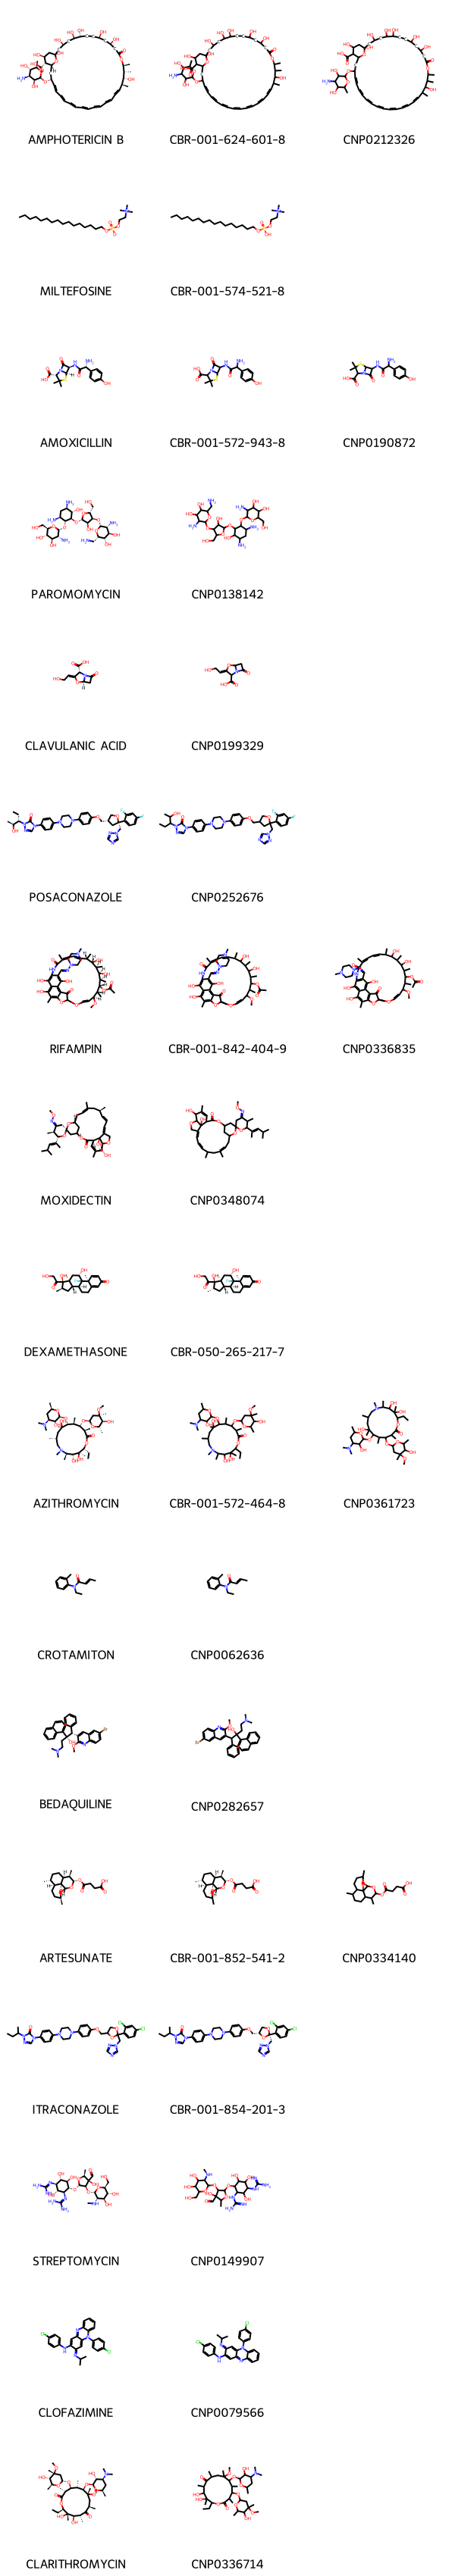

In [17]:
rdkit.Chem.Draw.MolsMatrixToGridImage(
    molsMatrix=main_data,
    subImgSize=(200, 200),
    legendsMatrix=main_labels,
)